# Data Exploration of USPTO Data

This document is initiated in August 2024. We are exploring several public datasets published by USPTO.

USPTO is hosting datasets at different pltaforms:
- https://developer.uspto.gov/data?f%5B0%5D=product_category%3A39198&f%5B1%5D=published_datasets%3A39166
- https://patentsview.org/download/data-download-tables
- https://patentsview.org/apis/purpose 
The first two links provide datasets available for download. The latter is an API where we can retrieve the data.

Both grants and application data are available. However, grants is only available after 2001. Application data is available after 1980. 
The datasets are split into several sub-datasets, where we can link by location id, inventor id, patent id and document id. For the following, I linked datasets on inventors and location based on location id and then it is linked to the overall patent grant dataset.


In [1]:
# libraries
import pandas as pd
import numpy as np
from os import listdir
import matplotlib.pyplot as plt

## Trajtenberg (2000) and Cockburn (2022)

After initial data exploration, the most appropriate datasets to replicate his paper are "historical masterfile" and "patent examination research dataset". The two datasets can be matched by application ID. 

- Historical masterfile contains information on publication number, patent number, NBER number, USPC number, application date, prior date, disposal date, application number, as well as other information. 
- Patent examination research dataset provides information on the parent country, foreign parent ID, foreign parent date and application number. 

In [150]:
# Read data

# location with rawlocation id
location_id = pd.read_csv("data/g_location_disambiguated.tsv", sep='\t') 

# inventors 
inventor_id = pd.read_csv("data/g_inventor_disambiguated.tsv", sep='\t') 

#applicants
applicant_id = pd.read_csv("data/g_applicant_not_disambiguated.tsv", sep='\t') 

#patent
patent_id = pd.read_csv("data/g_patent.tsv", sep='\t') 

#pct
pct_id = pd.read_csv("data/g_pct_data.tsv", sep='\t')

#application 
application_id = pd.read_csv("data/g_application.tsv", sep='\t') 

/var/folders/_c/hqgq6n0s7yl267nvktc1m9l00000gn/T/ipykernel_1142/1784761390.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  patent_id = pd.read_csv("data/g_patent.tsv", sep='\t')
/var/folders/_c/hqgq6n0s7yl267nvktc1m9l00000gn/T/ipykernel_1142/1784761390.py:19: DtypeWarning: Columns (0,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  application_id = pd.read_csv("data/g_application.tsv", sep='\t')


In [151]:
# Visualize fields  

print(location_id.head(3))
print(inventor_id.head(3))
print(patent_id.head(3))
print(applicant_id.head(3))
print(application_id.head(3))
print(pct_id.head(3))

                            location_id disambig_city disambig_state  \
0  00235947-16c8-11ed-9b5f-1234bde3cd05     Westfield             PA   
1  00236a27-16c8-11ed-9b5f-1234bde3cd05   Helfenstein             PA   
2  00236f47-16c8-11ed-9b5f-1234bde3cd05    Pine Forge             PA   

  disambig_country   latitude  longitude             county  state_fips  \
0               US  41.919237 -77.538874              Tioga        42.0   
1               US  40.750499 -76.447334  Schuylkill County        42.0   
2               US  40.281920 -75.692236       Berks County        42.0   

   county_fips  
0        117.0  
1        107.0  
2         11.0  
  patent_id  inventor_sequence         inventor_id  \
0  D1006496                  0  fl:we_ln:jiang-145   
1   6584128                  0  fl:ri_ln:kroeger-1   
2   4789863                  0     fl:th_ln:bush-1   

  disambig_inventor_name_first disambig_inventor_name_last gender_code  \
0                      Wenjing                     

In [161]:
# location country field cleaning. Sometimes Canada is referred as CA, ca, Canada, CANADA. We are including WO for those who have filed through WIPO. 

location_id['disambig_country'] = location_id['disambig_country'].astype(str)
location_id['disambig_country'] = location_id['disambig_country'].apply(lambda x: x.upper())

In [162]:
# Segment the dataset to only relevant fields
location_id = location_id[['location_id', 'disambig_country']].dropna(subset = ['location_id'])

inventor_id = inventor_id[['patent_id', 'location_id', 'inventor_id']].dropna(subset = ['location_id'])

#applicant_id = applicant_id[['patent_id', 'rawlocation_id', 'applicant_type']].dropna(subset = ['location_id'])

patent_id = patent_id[['patent_id', 'patent_type', 'patent_date']].dropna(subset = ['patent_id'])

pct_id = pct_id[['patent_id', 'published_or_filed_date', 'filed_country', 'application_kind']].dropna(subset = ['patent_id'])

application_id = application_id[['application_id', 'patent_id', 'filing_date']].dropna(subset = ['patent_id'])

Data is based on grants. However, filing date is used instead of patent date. The data would have the following fields:
- location id - merging inventor and location
- patent id
- application id
- patent type
- patent date
- filing date
- application kind from pct

At this point, we still need to figure out Canadian inventors who have filed with WIPO.

In [187]:
# merge different datasets to form one dataset that has 
data = pd.merge(inventor_id, location_id, how='left', on =["location_id"])
data = pd.merge(application_id, data, how='left', on =["patent_id"])
data = pd.merge(patent_id, data, how='left', on =["patent_id"])  # g_patent is largest file therefore left merge to not miss any rows
data = pd.merge(data, pct_id, how='left', on =["patent_id"])

In [188]:
data = data.reset_index()

In [189]:
data['patent_date'] = pd.to_datetime(data['patent_date'], errors='coerce')
data['filing_date'] = pd.to_datetime(data['filing_date'], errors='coerce')
data["filing_year"] = data["filing_date"].dt.year
data['grant_year'] = data["patent_date"].dt.year

In [190]:
overall_US = data.drop_duplicates(subset=['patent_id'])#.dropna(subset=['application_id'])

In [191]:
overall_US_counts = overall_US.groupby('grant_year').size().reset_index(name='counts')

In [194]:
overall_US_counts #382,559 from the lawyer article (https://www.lexology.com/library/detail.aspx?g=1170d66d-63b8-4901-b819-e88c67916a2f) 

,grant_year,counts
0,1976,70941
1,1977,69820
2,1978,70586
3,1979,52484
4,1980,66212
5,1981,71112
6,1982,63292
7,1983,62019
8,1984,72689
9,1985,77276


<Axes: xlabel='grant_year'>

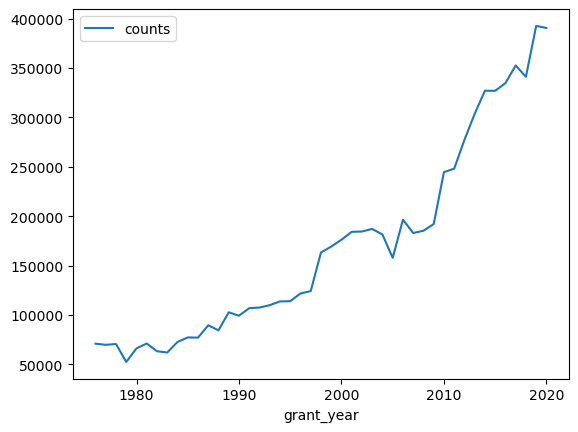

In [192]:
overall_US_counts[overall_US_counts['grant_year']<2021].plot(x="grant_year", y='counts')

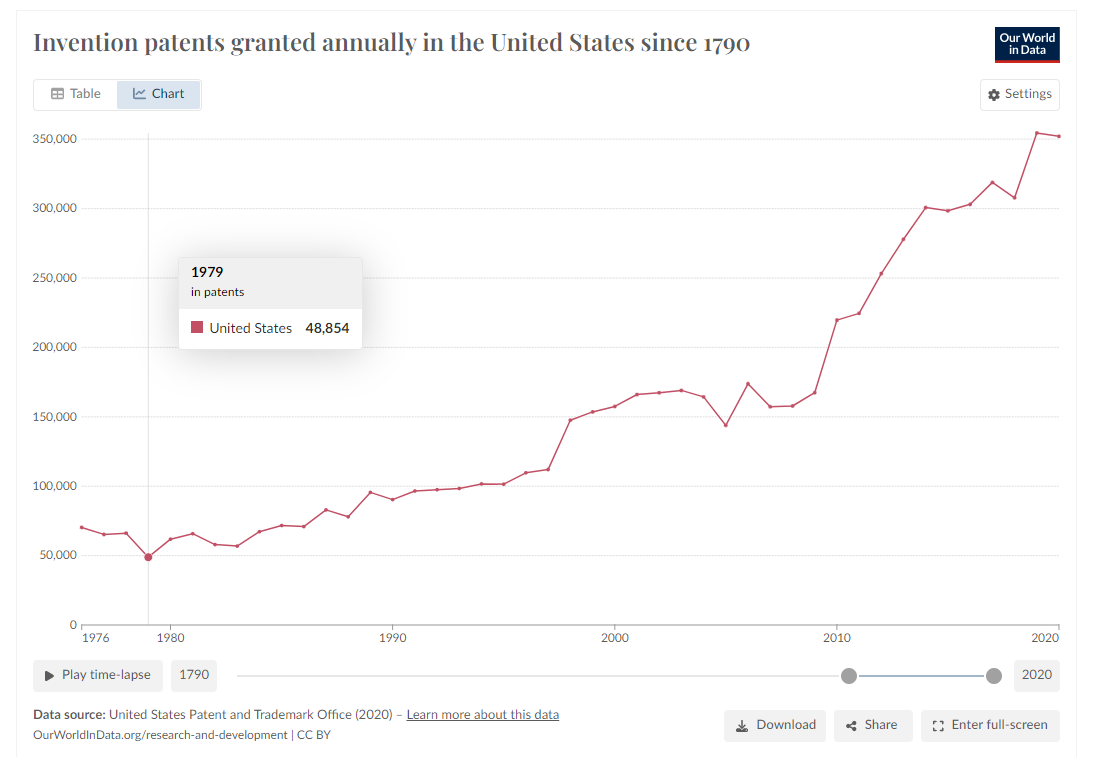
https://ourworldindata.org/grapher/annual-patents-invention-united-states-1790?time=1976..latest

In [224]:
better_data = overall_US.loc[(overall_US['disambig_country']=='JP') | (overall_US['disambig_country']=='CA')|(overall_US['disambig_country']=='FR')|(overall_US['disambig_country']=='CN')]

In [228]:
country_data = better_data.groupby(['grant_year', 'disambig_country']).size().reset_index(name='counts').pivot(index='grant_year', columns='disambig_country', values = 'counts')

<Axes: xlabel='grant_year'>

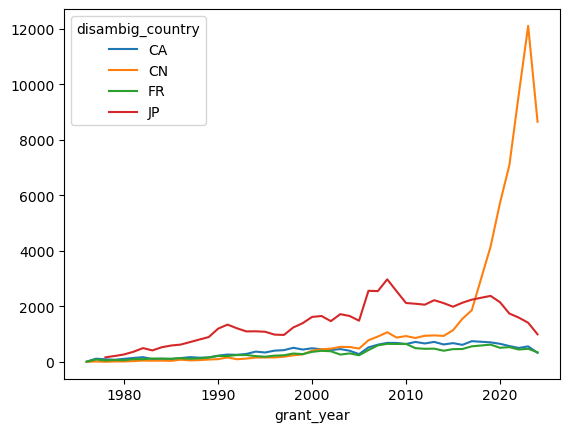

In [231]:
country_data.loc[country_data.index!=2018].plot()

In [234]:
# cpc classification
cpc_id = pd.read_csv("data/g_cpc_current.tsv", sep='\t') 

In [238]:
cpc_id = cpc_id[['patent_id', 'cpc_class']]

In [253]:
cpc_id['patent_id'] = cpc_id['patent_id'].astype(str)

/var/folders/_c/hqgq6n0s7yl267nvktc1m9l00000gn/T/ipykernel_1142/1455773481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpc_id['patent_id'] = cpc_id['patent_id'].astype(str)


In [250]:
better_data = better_data.reset_index()

In [254]:
cpc_data = pd.merge(better_data, cpc_id, on = 'patent_id')

In [259]:
cpc_country_data = cpc_data.groupby(['grant_year', 'disambig_country', 'cpc_class']).size().reset_index(name='counts')

In [263]:
cpc_country_data[cpc_country_data['disambig_country']=='CA']#.pivot(index = 'grant_year', columns='cpc_class', values = 'counts')

,grant_year,disambig_country,cpc_class,counts
0,2018,CA,A01,146
1,2018,CA,A21,1
2,2018,CA,A23,55
3,2018,CA,A24,12
4,2018,CA,A41,8
...,...,...,...,...
99,2018,CA,H10,18
100,2018,CA,H99,1
101,2018,CA,Y02,117
102,2018,CA,Y04,4
